In [2]:
import numpy as np

# ============================================================
# 0) 設定（ビン化に必要な最小）
# ============================================================
NPZ_PATH = "dataset_irregular.npz"
L_GRID   = 256
SEED     = 0

np.random.seed(SEED)

# ============================================================
# 1) 読み込み（1サンプル=[cycle_id, deg, s1, label]）
# ============================================================
d = np.load(NPZ_PATH, allow_pickle=True)
train_list = d["train_list"].tolist()
test_list  = d["test_list"].tolist()

def group_by_cycle(sample_list):
    """
    sample_list を cycle_id ごとにまとめて dict にする
    dict[cid] = (deg_array, y_array, label)
    """
    arr = np.asarray(sample_list, dtype=object)
    cid = arr[:,0].astype(int)
    deg = arr[:,1].astype(float)
    y   = arr[:,2].astype(float)
    lab = arr[:,3].astype(int)

    # cycle_id -> deg の順に並べる（後の処理が安定）
    order = np.lexsort((deg, cid))
    cid, deg, y, lab = cid[order], deg[order], y[order], lab[order]

    cycles = {}
    start = 0
    while start < len(cid):
        c = int(cid[start])
        end = start
        while end < len(cid) and int(cid[end]) == c:
            end += 1
        cycles[c] = (deg[start:end], y[start:end], int(lab[start]))
        start = end
    return cycles

train_cycles = group_by_cycle(train_list)
test_cycles  = group_by_cycle(test_list)

def count_labels_from_cycles(cycles_dict):
    labs = np.array([lab for (_,_,lab) in cycles_dict.values()], dtype=int)
    u, c = np.unique(labs, return_counts=True)
    return {int(k): int(v) for k, v in zip(u, c)}

print("\n[cycle counts]")
print("train cycles total:", len(train_cycles))
print("test  cycles total:", len(test_cycles))
print("train label counts:", count_labels_from_cycles(train_cycles))
print("test  label counts:", count_labels_from_cycles(test_cycles))


[cycle counts]
train cycles total: 700
test  cycles total: 1020
train label counts: {0: 700}
test  label counts: {0: 720, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}


# 説明（bin_cycle_nan がやっていること）

## 目的
不等間隔サンプル（角度 `deg[i]` と値 `y[i]`）を、0〜360度を `L` 個に分けた「升目（ビン）」に入れて  
**1サイクル = 長さ L の配列**に変換する。  
そのビンにデータが1点も無い場合は **欠損**として `NaN` のまま残す。

出力は次の3つ。
- `x_bin[b]`：ビン `b` の平均値（欠損はNaN）
- `mask[b]`：観測あり=1 / 欠損=0
- `cnt[b]`：ビン `b` に入った生点数

---

## 1) 角度を円環として正規化する
0度と360度は同じなので、角度は円環として扱う。  
コードの
`deg % 360.0`
は数式で

$deg'_i = deg_i \bmod 360$

を意味し、必ず $deg'_i \in [0,360)$ に入る。

例：
- $deg=-10^\circ \Rightarrow deg'=350^\circ$
- $deg=370^\circ \Rightarrow deg'=10^\circ$

---

## 2) 角度 → ビン番号へ変換する
0〜360度を `L` 個に等分するので、ビン幅は

$\Delta = \dfrac{360}{L}$ [deg]

各点 $deg'_i$ が入るビン番号は

$idx_i = \left\lfloor \dfrac{deg'_i}{360}L \right\rfloor
      = \left\lfloor \dfrac{deg'_i}{\Delta} \right\rfloor$

で、$idx_i \in \{0,1,\dots,L-1\}$。

---

## 3) ビンごとの合計と点数を集計する（数式が読める形＋数値例）

### 数式（表示されやすい形）
ビン番号を `idx[i]`、値を `y[i]` とします。  
ビン `b`（0〜L-1）について

- 合計（sumv）
  
  $
  \mathrm{sumv}[b] = \sum_{\{i \mid \mathrm{idx}[i] = b\}} y[i]
  $

- 個数（cnt）
  
  $
  \mathrm{cnt}[b] = \left|\{ i \mid \mathrm{idx}[i] = b \}\right|
  $

意味：
- `idx[i]=b` の点だけを集めて、その `y[i]` を全部足したものが `sumv[b]`
- `idx[i]=b` の点が何個あるかが `cnt[b]`

---

### 数値例（手で追える）

L=8（ビン0〜7）として、次の不等間隔データをビン化します。

- deg = [10, 20, 55, 130, 131, 220, 300]
- y   = [ 1,  2,  3,   4,   6,   5,   7]

ビン幅は 360/8=45° なので、ビン番号は `idx = floor(deg/45)` です。

| i | deg[i] | y[i] | idx[i]=floor(deg/45) | 入るビン |
|---|--------|------|-----------------------|----------|
| 0 | 10     | 1    | 0                     | bin0     |
| 1 | 20     | 2    | 0                     | bin0     |
| 2 | 55     | 3    | 1                     | bin1     |
| 3 | 130    | 4    | 2                     | bin2     |
| 4 | 131    | 6    | 2                     | bin2     |
| 5 | 220    | 5    | 4                     | bin4     |
| 6 | 300    | 7    | 6                     | bin6     |

ここから `sumv[b]` と `cnt[b]` を作ります。

#### bin0（b=0）
idx[i]=0 の行は i=0,1  
- sumv[0] = y[0] + y[1] = 1 + 2 = 3  
- cnt[0]  = 2（2点）

#### bin1（b=1）
idx[i]=1 の行は i=2  
- sumv[1] = y[2] = 3  
- cnt[1]  = 1

#### bin2（b=2）
idx[i]=2 の行は i=3,4  
- sumv[2] = y[3] + y[4] = 4 + 6 = 10  
- cnt[2]  = 2

#### bin3（b=3）
idx[i]=3 の行は無い  
- sumv[3] = 0（足すものが無いので初期値のまま）  
- cnt[3]  = 0

#### bin4（b=4）
idx[i]=4 の行は i=5  
- sumv[4] = 5  
- cnt[4]  = 1

#### bin5（b=5）
無い  
- sumv[5] = 0  
- cnt[5]  = 0

#### bin6（b=6）
idx[i]=6 の行は i=6  
- sumv[6] = 7  
- cnt[6]  = 1

#### bin7（b=7）
無い  
- sumv[7] = 0  
- cnt[7]  = 0

よって最終的に

- cnt  = [2, 1, 2, 0, 1, 0, 1, 0]
- sumv = [3, 3,10, 0, 5, 0, 7, 0]

この後に平均を作ると

- x_bin[b] = sumv[b]/cnt[b]（cnt[b]>0のとき）
- 欠損（cnt[b]=0）は NaN

となります。

---

## 4) ビン平均（欠損はNaN）とマスクを作る
観測があるビンを

$mask[b] =
\begin{cases}
1 & (cnt[b] > 0)\\
0 & (cnt[b] = 0)
\end{cases}$

とし、平均値を

$x_{bin}[b] =
\begin{cases}
\dfrac{sumv[b]}{cnt[b]} & (cnt[b] > 0)\\
NaN                     & (cnt[b] = 0)
\end{cases}$

で作る。

---

# 具体的な数値例（L=8）

## 入力
$L=8$ なので $\Delta=360/8=45^\circ$。

不等間隔データ：
- `deg = [10, 20, 55, 130, 131, 220, 300]`
- `y   = [1,  2,  3,  4,   6,   5,   7 ]`

## ビン番号
$idx=\lfloor deg/45 \rfloor$ より
- 10,20 → bin0
- 55 → bin1
- 130,131 → bin2
- 220 → bin4
- 300 → bin6

よって `idx = [0,0,1,2,2,4,6]`

## 集計
- `cnt = [2,1,2,0,1,0,1,0]`
- `sumv= [3,3,10,0,5,0,7,0]`

## 出力（平均）
- `x_bin = [3/2, 3/1, 10/2, NaN, 5/1, NaN, 7/1, NaN]`
- `x_bin = [1.5, 3.0, 5.0, NaN, 5.0, NaN, 7.0, NaN]`
- `mask  = [1,1,1,0,1,0,1,0]`

この `x_bin/mask/cnt` が「ビン化した結果（補間なし）」。


In [6]:
# ============================================================
# 2) ビン化（補間なし） + 信頼度（可視化なし）
#   目的：
#     不等間隔サンプル (deg, y) を
#     「0〜360度を L_GRID 個に分けた升目（ビン）」へ入れて
#     1サイクル = 長さL_GRIDの配列 に変換する
#
#   出力（1サイクルあたり）：
#     x_bin : 各ビンの平均値（そのビンにデータが無い=欠損は NaN）
#     mask  : 観測あり=1 / 欠損=0
#     cnt   : 各ビンに入った生データ点数（何点入ったか）
#
#   さらに、ビン化の「信頼度」を数値化：
#     coverage    : 観測ありビンの割合（= maskの平均）
#     miss_rate   : 欠損ビンの割合（= 1-coverage）
#     longest_gap : 欠損(0)が連続する最大長（円環を考慮）
#     n_obs       : そのサイクルの生データ点数
# ============================================================

deg_grid = np.linspace(0, 360, L_GRID, endpoint=False).astype(float)
deg_step = float(deg_grid[1] - deg_grid[0])  # 例：L_GRID=256なら約1.40625度

def bin_cycle_nan(deg, y, L=L_GRID):
    """
    1サイクル分の不等間隔データ (deg, y) をビン化する。

    入力：
      deg : 角度配列（不等間隔、0〜360度）
      y   : 値配列（degと同じ長さ）
      L   : ビン数（=L_GRID）

    手順：
      1) deg を [0,360) に丸める（負や360以上が来ても円環として扱う）
      2) 各degをビン番号 idx に変換する
         - 0度 -> idx=0
         - 359.9度 -> idx=L-1
      3) 同じビンに複数点が入ることがあるので
         - sumv[bin] に値を足し込む
         - cnt[bin]  に点数を足し込む
      4) cnt>0 のビンだけ平均を計算して x_bin に入れる
         欠損ビンは NaN のままにする
    """
    # ---- 1) 角度を円環として [0,360) に正規化 ----
    deg = np.asarray(deg, float) % 360.0
    y   = np.asarray(y, float)

    # ---- 2) deg -> ビン番号 idx ----
    # deg/360 は [0,1) に入るので、*Lして floor すると 0..L-1
    idx = np.floor(deg / 360.0 * L).astype(int)

    # 安全のため（degが360に非常に近いなどで）範囲外をクリップ
    idx = np.clip(idx, 0, L-1)

    # ---- 3) ビンごとの合計値と点数を作る ----
    sumv = np.zeros(L, float)   # ビンごとの y 合計
    cnt  = np.zeros(L, int)     # ビンごとの 点数

    # np.add.at は「同じidxが何回出ても正しく加算」してくれる
    np.add.at(sumv, idx, y)
    np.add.at(cnt,  idx, 1)

    # ---- 4) 平均値（欠損はNaN）とマスク ----
    mask = (cnt > 0).astype(np.int8)    # 観測あり=1, 欠損=0

    x_bin = np.full(L, np.nan, float)   # まず全部NaN（欠損扱い）
    # 観測ありビンだけ平均を入れる
    x_bin[mask == 1] = sumv[mask == 1] / cnt[mask == 1]

    return x_bin, mask, cnt


def longest_gap_circular(mask):
    """
    欠損(0)が連続する最大長（円環を考慮）。

    例（L=8）：
      mask = [1,1,0,0,0,1,1,1]
      欠損連続は t=2..4 の3つ → longest_gap=3

    円環を考慮するので、
      mask = [0,0,1,1,1,1,1,0]
      末尾の0と先頭の0がつながり欠損が3連続 → longest_gap=3
    """
    m = np.asarray(mask, int)
    L = len(m)

    # 全部欠損なら最大長はL
    if m.sum() == 0:
        return int(L)

    # 欠損を1、観測を0として並べる
    z = (m == 0).astype(int)

    # 円環を見るために2回つなげる（長さ2L）
    zz = np.r_[z, z]

    # 連続する1の最大長を数える
    best = 0
    cur  = 0
    for v in zz:
        if v == 1:
            cur += 1
            if cur > best:
                best = cur
        else:
            cur = 0

    # 円環なので最大でもLに制限
    return int(min(best, L))


def build_binned_nan(cycles_dict, L=L_GRID):
    """
    cycles_dict（train_cycles/test_cycles）全体をビン化して
    (Nサイクル, L_GRID) の行列にする。

    入力：
      cycles_dict: {cycle_id: (deg_array, y_array, label)}

    出力：
      Xnan : shape (N, L)  ビン平均（欠損はNaN）
      M    : shape (N, L)  欠損マスク
      Cnt  : shape (N, L)  ビン内点数
      ylab : shape (N,)    サイクルラベル
      cids : shape (N,)    cycle_id（昇順）
      rel  : dict          信頼度配列（coverage等）
    """
    # cycle_idを昇順に固定して、配列の行と対応づける
    cids = np.array(sorted(cycles_dict.keys()), dtype=int)
    N = len(cids)

    # 出力配列を確保
    Xnan = np.full((N, L), np.nan, float)  # 値（欠損はNaN）
    M    = np.zeros((N, L), np.int8)       # mask
    Cnt  = np.zeros((N, L), int)           # count
    ylab = np.zeros(N, int)                # label

    # 信頼度（1サイクル=1値）
    coverage   = np.zeros(N, float)  # 観測ありビンの割合
    miss_rate  = np.zeros(N, float)  # 欠損割合
    longest_gp = np.zeros(N, int)    # 連続欠損最大長
    n_obs      = np.zeros(N, int)    # 観測ありビン数（maskの1の数）
    n_raw      = np.zeros(N, int)    # 生データ点数（不等間隔点の数）

    for i, cid in enumerate(cids):
        deg, y, lab = cycles_dict[int(cid)]

        # ---- ビン化（補間なし）----
        x_bin, mask, cnt = bin_cycle_nan(deg, y, L)

        # 行列に格納（i行目がcidのサイクル）
        Xnan[i] = x_bin
        M[i]    = mask
        Cnt[i]  = cnt
        ylab[i] = int(lab)

        # ---- 信頼度 ----
        # coverage = 観測ありビン割合（maskの平均）
        cov = float(mask.mean())
        coverage[i]  = cov
        miss_rate[i] = 1.0 - cov

        # 欠損が固まっているか（円環）
        longest_gp[i] = longest_gap_circular(mask)

        # そのサイクルの生データ点数（不等間隔点の数）
        n_obs[i] = int(mask.sum())

        # 生データ点数（不等間隔点の数）
        n_raw[i] = int(len(deg))

    rel = {
        "coverage": coverage,
        "miss_rate": miss_rate,
        "longest_gap": longest_gp,
        "n_obs": n_obs,
        "n_raw": n_raw,
    }
    return Xnan, M, Cnt, ylab, cids, rel


# ---- 実行：train/test をビン化（補間なし）----
Xtr_nan, Mtr, Ctr, ytr, cidtr, rel_tr = build_binned_nan(train_cycles, L_GRID)
Xte_nan, Mte, Cte, yte, cidte, rel_te = build_binned_nan(test_cycles,  L_GRID)

# ---- 簡易ログ（動作確認）----
print("\n[binned (NaN kept)]")
print("Xtr_nan:", Xtr_nan.shape, "Mtr:", Mtr.shape, "Ctr:", Ctr.shape)
print("Xte_nan:", Xte_nan.shape, "Mte:", Mte.shape, "Cte:", Cte.shape)

print("\n[reliability summary: train]")
print("coverage mean/min:", float(rel_tr["coverage"].mean()), float(rel_tr["coverage"].min()))
print("miss_rate mean/max:", float(rel_tr["miss_rate"].mean()), float(rel_tr["miss_rate"].max()))
print("longest_gap mean/max:", float(rel_tr["longest_gap"].mean()), int(rel_tr["longest_gap"].max()))
print("n_obs (bins) mean/min:", float(rel_tr["n_obs"].mean()), int(rel_tr["n_obs"].min()))
print("n_raw (points) mean/min:", float(rel_tr["n_raw"].mean()), int(rel_tr["n_raw"].min()))


[binned (NaN kept)]
Xtr_nan: (700, 256) Mtr: (700, 256) Ctr: (700, 256)
Xte_nan: (1020, 256) Mte: (1020, 256) Cte: (1020, 256)

[reliability summary: train]
coverage mean/min: 0.9405078125 0.8984375
miss_rate mean/max: 0.0594921875 0.1015625
longest_gap mean/max: 1.0 1
n_obs (bins) mean/min: 240.77 230
n_raw (points) mean/min: 256.0 256


C:\Users\tsenz\AppData\Local\Temp\ipykernel_10012\2474136103.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


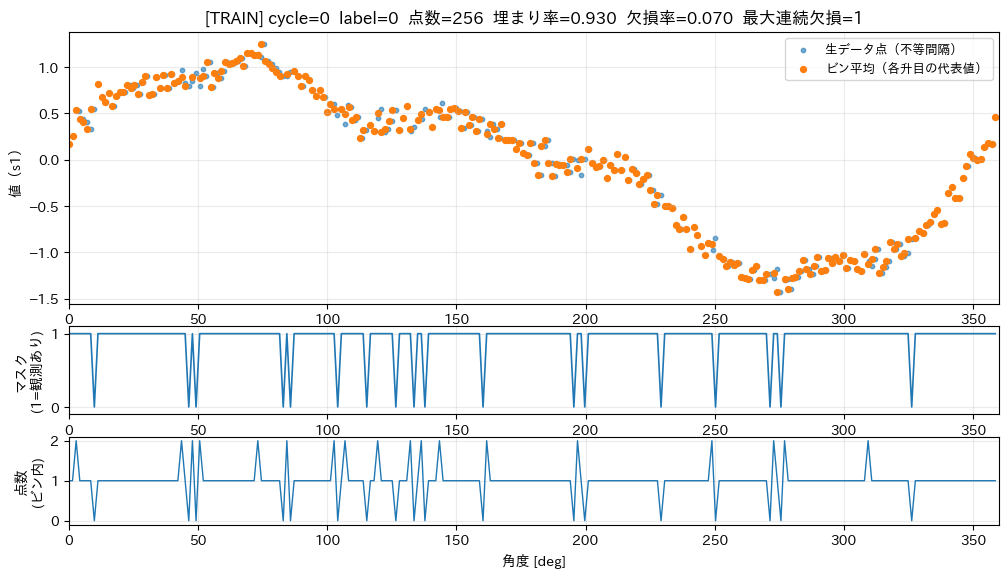

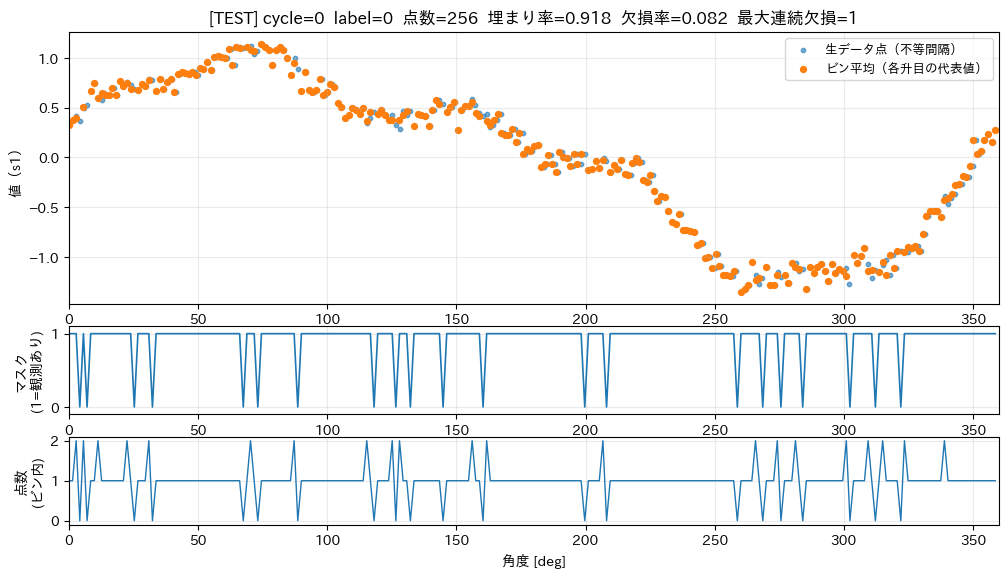

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# ============================================================
# 可視化 1) 代表1サイクル：生データ点 vs ビン化結果（補間なし）
# ============================================================
def plot_cycle_raw_vs_binned(cycles_dict, cid, L=L_GRID, タイトル接頭=""):
    deg_raw, y_raw, lab = cycles_dict[int(cid)]
    x_bin, mask, cnt = bin_cycle_nan(deg_raw, y_raw, L)

    cov  = float(mask.mean())
    miss = 1.0 - cov
    lg   = longest_gap_circular(mask)
    n    = int(len(deg_raw))

    fig = plt.figure(figsize=(12, 6.4))
    gs = fig.add_gridspec(3, 1, height_ratios=[3.4, 1.1, 1.1], hspace=0.15)

    ax0 = fig.add_subplot(gs[0])
    ax0.scatter(deg_raw, y_raw, s=10, alpha=0.6, label="生データ点（不等間隔）")
    ax0.scatter(deg_grid[mask==1], x_bin[mask==1], s=18, label="ビン平均（各升目の代表値）")
    ax0.set_xlim(0, 360)
    ax0.set_xlabel("角度 [deg]")
    ax0.set_ylabel("値（s1）")
    ax0.set_title(f"{タイトル接頭} cycle={cid}  label={lab}  点数={n}  埋まり率={cov:.3f}  欠損率={miss:.3f}  最大連続欠損={lg}")
    ax0.grid(True, alpha=0.25)
    ax0.legend(loc="upper right", fontsize=9)

    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    ax1.plot(deg_grid, mask, linewidth=1.2)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_yticks([0,1])
    ax1.set_ylabel("マスク\n(1=観測あり)")
    ax1.grid(True, alpha=0.25)

    ax2 = fig.add_subplot(gs[2], sharex=ax0)
    ax2.plot(deg_grid, cnt, linewidth=1.0)
    ax2.set_ylabel("点数\n(ビン内)")
    ax2.set_xlabel("角度 [deg]")
    ax2.grid(True, alpha=0.25)

    plt.tight_layout()
    plt.show()




# ============================================================
# 実行例
# ============================================================
train_normal_cids = [cid for cid,(deg,y,lab) in train_cycles.items() if lab == 0]
if len(train_normal_cids) > 0:
    cid0 = train_normal_cids[0]
    plot_cycle_raw_vs_binned(train_cycles, cid0, L_GRID, タイトル接頭="[TRAIN]")

cid1 = list(test_cycles.keys())[0]
plot_cycle_raw_vs_binned(test_cycles, cid1, L_GRID, タイトル接頭="[TEST]")



# 特徴量の算出

記号の約束（表内で使う）
L は 1サイクルのビン数。m[i] は観測あり=1、欠損=0 のマスク。
観測インデックス集合を $O=\{\,i\in\{0,\dots,L-1\}\mid m[i]=1\,\}$ とする。
「Oの個数（観測点数）」は $n_{\mathrm{obs}}=\sum_{i=0}^{L-1} m[i]$ と書く（表内ではこの形で書く）。

## 記号の読み方（abs と 個数を混同しないための統一）
| 表記 | 意味 | 例 |
|---|---|---|
| $\mathrm{abs}(a)$ | 絶対値（大きさ） | $\mathrm{abs}(-3)=3$ |
| $\mathrm{count}(S)$ | 集合 $S$ の要素数（個数） | $\mathrm{count}(\{2,5,8\})=3$ |
| $\sum_{i\in S}$ | $S$ に入っている $i$ だけ足す | $\sum_{i\in\{1,3\}} f(i)=f(1)+f(3)$ |

---

## 共通の下ごしらえ（ビン化系で共通に使う定義）
| 名前 | 定義 |
|---|---|
| ビン波形 | $x_{\mathrm{bin}}[i]\quad (i=0,\dots,L-1)$ |
| ビンマスク | $m[i]\in\{0,1\}$（観測あり$=1$、欠損$=0$） |
| 参照波形 | $x_{\mathrm{ref}}[i]\quad (i=0,\dots,L-1)$ |
| 参照マスク | $m_{\mathrm{ref}}[i]$（通常は全て$1$でもよい） |
| 比較できる位置集合 | $\mathrm{ok}=\{\, i \mid m[i]=1,\ m_{\mathrm{ref}}[i]=1,\ x_{\mathrm{bin}}[i],x_{\mathrm{ref}}[i]\ \text{が有限}\,\}$ |
| ok上の平均 | $\mathrm{mean}_{\mathrm{ok}}(z)=\dfrac{1}{\mathrm{count}(\mathrm{ok})}\sum_{i\in \mathrm{ok}} z[i]$ |
| 円環シフト | $\mathrm{roll}(x,s)[i]=x[(i-s)\bmod L]$（この定義に合わせて符号を統一） |
| ok上の相関 | $\mathrm{corr}_{\mathrm{ok}}(x,y)=\dfrac{A}{\sqrt{B_x}\sqrt{B_y}}$<br>$A=\sum_{i\in\mathrm{ok}}(x[i]-\mathrm{mean}_{\mathrm{ok}}(x))(y[i]-\mathrm{mean}_{\mathrm{ok}}(y))$<br>$B_x=\sum_{i\in\mathrm{ok}}(x[i]-\mathrm{mean}_{\mathrm{ok}}(x))^2$<br>$B_y=\sum_{i\in\mathrm{ok}}(y[i]-\mathrm{mean}_{\mathrm{ok}}(y))^2$ |

---

## 特徴量の数式（abs と count を明示）
| 区分 | 特徴量名 | ビン化必要？ | 入力（推奨形） | 定義（数式） | 注意（欠損/信頼度の扱い） |
|---|---|---:|---|---|---|
| 信頼度 | coverage | はい | $m[0..L-1]$ | $\mathrm{coverage}=\dfrac{1}{L}\sum_{i=0}^{L-1} m[i]$ | ゲート用（MSPCに混ぜない推奨）。 |
| 信頼度 | miss_rate | はい | $m[\ ]$ | $\mathrm{miss\_rate}=1-\mathrm{coverage}$ | coverageと同情報。どちらか片方。 |
| 信頼度 | n_obs | はい | $m[\ ]$ | $n_{\mathrm{obs}}=\sum_{i=0}^{L-1} m[i]$ | coverageと比例（$n_{\mathrm{obs}}=L\cdot\mathrm{coverage}$）。 |
| 信頼度 | longest_gap | はい | $m[\ ]$ | $\mathrm{longest\_gap}=\max(\text{「}m[i]=0\text{ の連続長」})$ | 円環として数えるか（端も連結）を実装で固定。 |
| 異常（横ずれ） | phase_shift_deg | はい | $x_{\mathrm{bin}}[\ ],\ x_{\mathrm{ref}}[\ ]$（＋$m,m_{\mathrm{ref}}$） | $s^*=\arg\max_{s=0,\dots,L-1}\ \mathrm{corr}_{\mathrm{ok}}\!\left(x_{\mathrm{ref}},\ \mathrm{roll}(x_{\mathrm{bin}},s)\right)$<br>$\mathrm{phase\_shift\_deg}=\dfrac{360}{L}\,s^*$ | 0/360近傍の折返しが必要なら $\mathrm{wrap}_{180}(\phi)=((\phi+180)\bmod 360)-180$。 |
| 異常（横ずれ信頼度） | phase_corr_max | はい | $x_{\mathrm{bin}}[\ ],\ x_{\mathrm{ref}}[\ ]$（＋$m,m_{\mathrm{ref}}$） | $\mathrm{phase\_corr\_max}=\max_{s=0,\dots,L-1}\ \mathrm{corr}_{\mathrm{ok}}\!\left(x_{\mathrm{ref}},\ \mathrm{roll}(x_{\mathrm{bin}},s)\right)$ | 低いと位相推定が怪しい→ゲートに使える。 |
| 異常（上下） | offset_abs | はい | $x_{\mathrm{bin}}[\ ],\ x_{\mathrm{ref}}[\ ]$（＋$m,m_{\mathrm{ref}}$） | $x_{\mathrm{al}}=\mathrm{roll}(x_{\mathrm{bin}},s^*)$<br>$\mathrm{offset}=\mathrm{mean}_{\mathrm{ok}}(x_{\mathrm{al}}-x_{\mathrm{ref}})$<br>$\mathrm{offset\_abs}=\mathrm{abs}(\mathrm{offset})$ | ok上で平均との差（欠損はokで排除）。 |
| 異常（形状） | shape_rms | はい | $x_{\mathrm{bin}}[\ ],\ x_{\mathrm{ref}}[\ ]$（＋$m,m_{\mathrm{ref}}$） | $x_{\mathrm{al}}=\mathrm{roll}(x_{\mathrm{bin}},s^*)$<br>$\mathrm{offset}=\mathrm{mean}_{\mathrm{ok}}(x_{\mathrm{al}}-x_{\mathrm{ref}})$<br>$x_{\mathrm{corr}}=x_{\mathrm{al}}-\mathrm{offset}$<br>$r=x_{\mathrm{corr}}-x_{\mathrm{ref}}$<br>$\mathrm{shape\_rms}=\sqrt{\mathrm{mean}_{\mathrm{ok}}(r^2)}$ | スパイクに弱ければ $r$ をクリップ/トリムしてからRMS。 |
| 異常（形状） | shape_1minus_corr | はい | $x_{\mathrm{bin}}[\ ],\ x_{\mathrm{ref}}[\ ]$（＋$m,m_{\mathrm{ref}}$） | $x_{\mathrm{al}}=\mathrm{roll}(x_{\mathrm{bin}},s^*)$<br>$\mathrm{offset}=\mathrm{mean}_{\mathrm{ok}}(x_{\mathrm{al}}-x_{\mathrm{ref}})$<br>$x_{\mathrm{corr}}=x_{\mathrm{al}}-\mathrm{offset}$<br>$\mathrm{shape\_1minus\_corr}=1-\mathrm{corr}_{\mathrm{ok}}(x_{\mathrm{corr}},x_{\mathrm{ref}})$ | RMSと補完関係。どちらか1本なら shape_rms が扱いやすいことが多い。 |
| 異常（スパイク強さ） | spike_max | はい | $r[\ ]$（残差）＋ok | $r=(\mathrm{roll}(x_{\mathrm{bin}},s^*)-\mathrm{offset})-x_{\mathrm{ref}}$<br>$\mathrm{spike\_max}=\max_{i\in\mathrm{ok}}\ \mathrm{abs}(r[i])$ | 単発ノイズにも反応しやすい。 |
| 異常（スパイク数） | spike_count | はい | $r[\ ]$（残差）＋ok | $r_{\mathrm{med}}=\mathrm{median}_{i\in\mathrm{ok}}(r[i])$<br>$\mathrm{MAD}=\mathrm{median}_{i\in\mathrm{ok}}\left(\mathrm{abs}(r[i]-r_{\mathrm{med}})\right)$<br>$\sigma_{\mathrm{rob}}=1.4826\,\mathrm{MAD}$<br>$\tau=k\,\sigma_{\mathrm{rob}}$<br>$\mathrm{spike\_count}=\sum_{i\in\mathrm{ok}} \mathbf{1}\!\left(\mathrm{abs}(r[i]-r_{\mathrm{med}})>\tau\right)$ | $k$は例として6など。正常calibで分位点調整が現実的。 |
| 異常（周波数：全体） | ls_hl（LS） | いいえ（ビン化なし推奨） | 不等間隔 $(\theta_j,x_j)$（$j=1,\dots,N$） | $u_j=\theta_j/360$<br>$\omega_k=2\pi k\quad (k=1,\dots,K)$<br>$P(k)=\mathrm{lombscargle}\!\left(u,\ x,\ \omega_k;\ \mathrm{floating\_mean}=\mathrm{True},\ \mathrm{normalize}=\text{"power"}\right)$<br>$Z(k)=\log(P(k)+\varepsilon)$<br>$\mathrm{ls\_hl}=\mathrm{mean}_{k\in\mathrm{High}} Z(k)-\mathrm{mean}_{k\in\mathrm{Low}} Z(k)$ | SciPyの $P(k)$ は periodogram（power）。$x$ にオフセット（平均のズレ）があり得るなら $\mathrm{floating\_mean}=\mathrm{True}$ を推奨。$\mathrm{normalize}$ は常に同じ設定で固定。必要なら振幅の目安：$A(k)=2\sqrt{P(k)/N}$（$\mathrm{normalize}=\text{"power"}$ のとき）。 |

### 推奨セット（MSPC入力に入れる最小構成）
- offset_abs
- phase_shift_deg
- phase_corr_max
- cwt_hl
- shape_rms
- spike_max
- spike_count

### 推奨セット（MSPCに入れない＝ゲート/ログ用）
- coverage
- longest_gap
- n_obs
（miss_rateはcoverageの代替なので通常不要）


# 特徴量算出 設計書（下請け実装向け / 高速化前提 / v1.3）

本設計は「1サイクルのデータ」から特徴量を算出し、MSPC(PCA)へ入力するベクトルを作るための仕様である。
方針は次の固定とする。

(1) 位相推定（相互相関）＝ FFT で全シフト一括計算（欠損マスク込み）
(2) 周波数特徴 ＝ SciPy の Lomb-Scargle（LS）
(3) それ以外（上下・形状・スパイク・信頼度）＝ ビン化済み配列（x_bin, m）で計算
(4) 位相推定の“不確かさ”は phase_corr_max のみ採用（当面）

本設計では「ゲート条件（判定保留など）」は扱わない。
ただし「ゼロ割れ回避」などの数値保護（内部保護）は実装に含める。

---

## 1. 最初に：計算する特徴量の個数と全体像

### 1.1 計算する特徴量の数（1サイクルあたり）
| 種別 | 特徴量数 | 内訳 |
|---|---:|---|
| MSPC入力（PCAに入れる） | 8 | offset_abs, phase_shift_deg, phase_corr_max, ls_hl, shape_rms, shape_1minus_corr, spike_max, spike_count |
| ログ用（PCAに入れない） | 3 | coverage, n_obs, longest_gap |
| 合計 | 11 | 上記の合計 |

### 1.2 全体フロー（依存関係）
入力は「生データ（theta_raw, x_raw）」と「ビン化済み（x_bin, m）」の両方を想定する。
ビン化済みが無い場合は bin_cycle_mean を先に呼んで作る。

(1) reliability_metrics(m) → coverage, n_obs, longest_gap  
(2) estimate_phase_corr_fft(x_bin, m, x_ref, m_ref) → s_star, phase_shift_deg, phase_corr_max  
(3) residual_metrics(x_bin, m, x_ref, m_ref, s_star) → offset_abs, shape_rms, shape_1minus_corr, spike_max, spike_count  
(4) ls_hl_scipy(theta_raw, x_raw) → ls_hl  
(5) 8特徴量を feat_mspc に格納、3特徴量を feat_log に格納して返す

---

## 2. データ規約（必須）

### 2.1 用語
L: 1サイクルを等分したビン数（例 256）  
N: 生データの点数（不等間隔の観測点の数）

### 2.2 入力（1サイクル分）
生データ（LS用）
- theta_raw: shape (N,) 角度[deg]（任意範囲可、内部で mod 360）
- x_raw:     shape (N,) 値

ビン化済み（相互相関・残差系・信頼度用）
- x_bin: shape (L,) float（欠損は NaN 推奨）
- m:     shape (L,) int8（観測あり=1、欠損=0）

参照（テンプレート）
- x_ref:  shape (L,) float
- m_ref:  shape (L,) int8（通常は全て1）

### 2.3 出力（1サイクル分）
feat_mspc: dict[str, float]（PCAへ入れる8特徴量）  
feat_log : dict[str, float]（ログ用3特徴量）

---

## 3. “マスク”の説明（下請け向け：具体）

### 3.1 m[i] の意味（最重要）
m[i]=1: i番目のビンに観測点が1つ以上あり、そのビン値 x_bin[i] が定義できる  
m[i]=0: 観測点が無い（欠損）。この位置の x_bin[i] は NaN（推奨）

絶対ルール：
欠損を NaN→0 で埋めて、そのまま相関やRMSを取るのは禁止。
必ず m を使って「計算に入れない」ようにする。

### 3.2 ロール（円環シフト）の定義
roll(x, s)[i] = x[(i - s) mod L]  
（NumPy の np.roll(x, s) と同じ向き：s>0 で右シフト）

---

## 4. 関数一覧（実装単位）とファイル構成案

下請けはこの一覧どおりにファイルと関数を作る（関数名・引数名を固定）。

| ファイル | 関数 | 役割 |
|---|---|---|
| binning.py | bin_cycle_mean | 生データ→(x_bin, m, cnt) |
| reliability.py | reliability_metrics | coverage, n_obs, longest_gap |
| phase_fft.py | estimate_phase_corr_fft | FFT相互相関（欠損込み正規化）で s_star と phase_corr_max |
| residuals.py | residual_metrics | offset_abs, shape_rms, shape_1minus_corr, spike_max, spike_count を一括 |
| ls_features.py | ls_hl_scipy | SciPy lombscargle で ls_hl |
| pipeline.py | compute_cycle_features | 入口：上を統合して feat_mspc/feat_log |

---

## 5. 各関数の設計仕様（I/O・処理・高速化）

### 5.1 bin_cycle_mean（ビン化）
関数：
bin_cycle_mean(theta_raw, x_raw, L) -> (x_bin, m, cnt)

入力：
theta_raw: (N,) float  
x_raw: (N,) float  
L: int

出力：
x_bin: (L,) float（欠損は NaN 推奨）  
m: (L,) int8  
cnt: (L,) int32

定義：
theta_mod = (theta_raw % 360)  
idx = floor(theta_mod / 360 * L) を int 化し、範囲[0, L-1]へクリップ  
各ビン i で  
cnt[i] = 点数  
x_bin[i] = 平均（sum/cnt）  
m[i] = 1(cnt>0), 0(cnt=0)

高速化要件（必須）：
Python for で点を回さない。numpy の bincount（重み付き）などで sum と cnt を一括集計する。

---

### 5.2 reliability_metrics（信頼度：ログ用）
関数：
reliability_metrics(m, circular=True) -> (coverage, n_obs, longest_gap)

定義：
coverage = (1/L) * sum_i m[i]  
n_obs    = sum_i m[i]  
longest_gap = 連続する m[i]=0 の最大長（circular=True のとき端を連結）

高速化要件：
longest_gap は O(L) 1パス（または2パス）で計算する。

---

### 5.3 estimate_phase_corr_fft（FFT相互相関で位相推定：本丸）
目的：
全シフトの「欠損込み正規化相関」を FFT で一括計算し、
s_star（最良シフト）と phase_corr_max（最大相関）を返す。

関数：
estimate_phase_corr_fft(x_bin, m, x_ref, m_ref, min_n=8) -> (s_star, phase_shift_deg, phase_corr_max)

入力：
x_bin: (L,) float  
m: (L,) int8  
x_ref: (L,) float  
m_ref: (L,) int8  
min_n: int（重なり点数 n[s] がこれ未満のシフトは相関無効＝内部保護）

出力：
s_star: int（0..L-1）  
phase_shift_deg: float（360/L * s_star）  
phase_corr_max: float

マスク込み正規化相関の定義（全シフト s=0..L-1）：
まず系列を作る（要素ごとの積）
Mx  = m  
X   = m * x_bin  
X2  = m * (x_bin^2)  
My  = m_ref  
Y   = m_ref * x_ref  
Y2  = m_ref * (x_ref^2)

円環相互相関を
(A ⋆ B)[s] = sum_{i=0..L-1} A[i] * B[(i-s) mod L]
と定義する。

FFTで以下を一括計算する（長さLの配列）
n[s]       = (My ⋆ Mx)[s]  
sum_x[s]   = (My ⋆ X )[s]  
sum_x2[s]  = (My ⋆ X2)[s]  
sum_y[s]   = (Y  ⋆ Mx)[s]  
sum_y2[s]  = (Y2 ⋆ Mx)[s]  
sum_xy[s]  = (Y  ⋆ X )[s]

ここから相関を作る
cov[s]   = sum_xy[s] - (sum_x[s] * sum_y[s]) / n[s]  
var_x[s] = sum_x2[s] - (sum_x[s]^2) / n[s]  
var_y[s] = sum_y2[s] - (sum_y[s]^2) / n[s]  
corr[s]  = cov[s] / sqrt(var_x[s] * var_y[s])

内部保護（ゲートではない。ゼロ割れ・無意味な相関を防ぐだけ）：
n[s] < min_n のとき corr[s] は無効（例：-inf）  
var_x[s] <= 0 または var_y[s] <= 0 のとき corr[s] は無効（例：-inf）  
FFT丸めで var が微小負になる場合があるので var = max(var, 0) の保護を入れる（推奨）

最終出力：
s_star = argmax_s corr[s]  
phase_shift_deg = 360/L * s_star  
phase_corr_max = corr[s_star]

高速化要件（必須）：
実数FFT（rfft/irfft）を使う。  
参照側（My, Y, Y2）の FFT はテンプレ固定なのでキャッシュする。  
1サイクルごとのFFT回数を最小化する。

---

### 5.4 residual_metrics（残差系：offset/shape/spike を一括）
目的：
位相整列と上下補正をした後のズレを、同じ中間量を使い回して高速算出する。

関数：
residual_metrics(x_bin, m, x_ref, m_ref, s_star, k_spike=6.0, min_ok=8)
-> (offset_abs, shape_rms, shape_1minus_corr, spike_max, spike_count)

入力：
x_bin, m, x_ref, m_ref  
s_star: int  
k_spike: float  
min_ok: int（okが小さすぎる場合は NaN を返す。内部保護）

出力：
offset_abs: float  
shape_rms: float  
shape_1minus_corr: float  
spike_max: float  
spike_count: float（NaNもあり得るので float 扱い推奨）

定義：
x_al = roll(x_bin, s_star)  
m_al = roll(m, s_star)

okmask = (m_al==1) かつ (m_ref==1) かつ finite(x_al) かつ finite(x_ref)  
ok = okmask が True の位置

count(ok) < min_ok の場合、全出力を NaN（内部保護）

offset = mean_ok(x_al - x_ref)  
offset_abs = abs(offset)

x_corr = x_al - offset  
r = x_corr - x_ref

shape_rms = sqrt(mean_ok(r^2))

shape_corr = corr_ok(x_corr, x_ref)（ok上のみで相関）  
shape_1minus_corr = 1 - shape_corr

spike_max = max_ok(abs(r))

spike_count（MAD方式）：
r_med = median_ok(r)  
MAD = median_ok(abs(r - r_med))  
sigma_rob = 1.4826 * MAD  
tau = k_spike * sigma_rob  
spike_count = sum_ok( I(abs(r - r_med) > tau) )

高速化要件：
ok抽出は boolean mask で一括。Pythonループ禁止。

---

### 5.5 ls_hl_scipy（周波数：Lomb-Scargle）
関数：
ls_hl_scipy(theta_raw, x_raw, K, low_ks, high_ks, eps=1e-12,
            floating_mean=True, normalize="power") -> (ls_hl)

定義（SciPy準拠）：
u_j = (theta_raw % 360) / 360  
omega_k = 2πk, k=1..K  
P(k) = scipy.signal.lombscargle(u, x, omega, floating_mean=floating_mean, normalize=normalize)  
Z(k) = log(P(k)+eps)  
ls_hl = mean_{k∈high_ks} Z(k) - mean_{k∈low_ks} Z(k)

高速化要件：
omega 配列（長さK）と low/high の index をキャッシュ可能な設計にする。

---

### 5.6 compute_cycle_features（入口：統合）
関数：
compute_cycle_features(theta_raw, x_raw, x_bin, m, x_ref, m_ref, params) -> (feat_mspc, feat_log)

feat_mspc（8本）：
offset_abs, phase_shift_deg, phase_corr_max, ls_hl, shape_rms, shape_1minus_corr, spike_max, spike_count

feat_log（3本）：
coverage, n_obs, longest_gap

---

## 6. 具体例（数値とデータ行列で理解する：不足分を追加）

ここでは L=8 の小例で、下請けが「配列をどう加工しているか」を手で追えるように書く。
実装はFFTやSciPyで高速に行うが、意味の理解が目的。

### 6.1 例データ（ビン化済み）
L=8 のとき、1ビン=45度。

x_bin（欠損は NaN）：
x_bin = [ 12, NaN,  8, NaN, NaN,  3, NaN,  8 ]

m（観測マスク）：
m     = [  1,   0,  1,   0,   0,  1,   0,  1 ]

参照（欠損なし）：
x_ref = [ 11, 10,  9,  8,  7,  6,  7,  9 ]
m_ref = [  1,  1,  1,  1,  1,  1,  1,  1 ]

このとき信頼度：
coverage = (1/8) * (1+0+1+0+0+1+0+1) = 4/8 = 0.5  
n_obs = 4

---

### 6.2 位相推定（s_star と phase_corr_max）の意味（“相関列”の見方）
estimate_phase_corr_fft は、s=0..7 の各シフトで相関 corr[s] を計算し、その最大を取る。

この例では（説明のために結果だけ示す）：
corr = [ 0.9981, 0.6935, -0.0180, -0.6300, -0.8953, -0.7989, -0.1675, 0.5577 ]

最大は s=0 なので：
s_star = 0  
phase_shift_deg = 360/8 * 0 = 0  
phase_corr_max = 0.9981

ポイント：
欠損があっても「mで除外した上で、平均を引いて分散で割る」相関になっているので、
欠損を0扱いして壊れることがない。

---

### 6.3 残差系（offset_abs, shape_rms, shape_1minus_corr, spike_*）を“行列”で追う
ここでは s_star=0（シフトなし）なので roll は変わらない。

(1) 位相整列（x_al と m_al）
x_al = roll(x_bin, 0) = [ 12, NaN, 8, NaN, NaN, 3, NaN, 8 ]  
m_al = roll(m,     0) = [  1,  0, 1,  0,   0, 1,  0, 1 ]

(2) ok の抽出（両方観測ありの位置）
m_ref は全て1なので ok は「m_al==1 の位置」になる。
ok のインデックスは
ok = {0, 2, 5, 7}

(3) ok 上だけを“短いベクトル”として取り出す（これが下請けの理解ポイント）
x_al_ok = [ x_al[0], x_al[2], x_al[5], x_al[7] ] = [12, 8, 3, 8]  
x_ref_ok= [ x_ref[0],x_ref[2],x_ref[5],x_ref[7] ]= [11, 9, 6, 9]

(4) offset（上下ズレの平均）と offset_abs
差分 d_ok = x_al_ok - x_ref_ok = [ 1, -1, -3, -1 ]  
offset = mean(d_ok) = (1 + (-1) + (-3) + (-1))/4 = -1  
offset_abs = abs(offset) = 1

(5) 上下補正 x_corr と残差 r
x_corr_ok = x_al_ok - offset = [12, 8, 3, 8] - (-1) = [13, 9, 4, 9]  
r_ok = x_corr_ok - x_ref_ok = [13,9,4,9] - [11,9,6,9] = [ 2, 0, -2, 0 ]

(6) shape_rms（全体ズレの大きさ）
r_ok^2 = [4, 0, 4, 0]  
mean(r_ok^2) = (4+0+4+0)/4 = 2  
shape_rms = sqrt(2) = 1.4142

(7) shape_1minus_corr（似てなさ：相関ベース）
shape_corr = corr_ok(x_corr_ok, x_ref_ok) ≈ 0.9981  
shape_1minus_corr = 1 - shape_corr ≈ 0.0019

(8) spike_max（最大の尖り）
spike_max = max(abs(r_ok)) = max([2,0,2,0]) = 2

(9) spike_count（尖りの個数：MADしきい値）
r_med = median(r_ok) = 0  
abs(r_ok - r_med) = [2,0,2,0]  
MAD = median([2,0,2,0]) = 1  
sigma_rob = 1.4826 * 1 = 1.4826  
k_spike=6 のとき tau = 6 * 1.4826 = 8.8956  
abs(r_ok - r_med) > tau となる点は無いので spike_count = 0

このように、欠損は ok の時点で除外され、以降の計算は「短いベクトル」で進む。
下請けが実装するときも、まず ok 抽出→短ベクトル化→集計、の順が安全。

---

## 7. 性能設計（ここを守れば速い）

| ブロック | 主な計算 | 計算量目安 | キャッシュ推奨 |
|---|---|---:|---|
| ビン化 | bincount等 | O(N+L) | なし |
| 位相推定 | FFT相関（複数本） | O(L log L) | 参照側のFFT（My,Y,Y2）を保持 |
| 残差系 | roll + ok抽出 + 集計 | O(L) | なし |
| LS | lombscargle | 概ね O(NK) | omega と low/high index を保持 |

---

## 8. 提出物（下請けが必ず出すもの）

(1) 4章のファイル構成案どおりに実装（関数名・引数名を固定）  
(2) pipeline.py の compute_cycle_features が 11特徴量（8+3）を返す  
(3) 6章の L=8 数値例を単体テスト化し、少なくとも以下を確認  
    - reliability_metrics が coverage=0.5, n_obs=4 を返す  
    - residual_metrics が offset_abs=1, shape_rms≈1.4142, shape_1minus_corr≈0.0019, spike_max=2, spike_count=0 を返す  
    - 欠損（m=0）の位置を計算に混ぜていないこと

---


In [1]:
# ============================================================
# 特徴量算出（Notebook貼り付け用コード）
#  方針：
#   - 位相推定（相互相関）: 欠損マスク込み正規化相関を FFT で全シフト一括
#   - 周波数（LS）        : scipy.signal.lombscargle（この環境は precenter/normalize の旧API）
#   - その他              : ビン化済み（x_bin, m）で計算
# ============================================================

import numpy as np
from dataclasses import dataclass
from typing import Dict, Iterable, Optional, Tuple

try:
    from scipy.signal import lombscargle
except Exception as e:
    lombscargle = None
    print("SciPy lombscargle が import できませんでした:", e)

# ============================================================
# 0) 共通ユーティリティ（絶対にここを守る）
#   - 欠損は「0埋め」ではなく「マスクで除外」
#   - m=0 の場所は計算に入れない
# ============================================================

def _as_float_array(x) -> np.ndarray:
    return np.asarray(x, dtype=float)

def _as_int8_mask(m) -> np.ndarray:
    return np.asarray(m, dtype=np.int8)

def _finite_mask(x: np.ndarray) -> np.ndarray:
    return np.isfinite(x)

def _roll(x: np.ndarray, s: int) -> np.ndarray:
    # roll(x,s)[i] = x[(i-s) mod L] と同じ向き（np.rollは右シフト）
    return np.roll(x, int(s))

def _mean_ok(z: np.ndarray) -> float:
    return float(np.mean(z)) if z.size > 0 else np.nan

def _corr_1d(x: np.ndarray, y: np.ndarray) -> float:
    """
    x,y: 1次元ベクトル（すでに欠損除外済み、同じ長さ）
    """
    if x.size == 0 or y.size == 0 or x.size != y.size:
        return np.nan
    mx = float(np.mean(x))
    my = float(np.mean(y))
    dx = x - mx
    dy = y - my
    num = float(np.sum(dx * dy))
    den = float(np.sqrt(np.sum(dx * dx) * np.sum(dy * dy)))
    if den <= 0.0 or not np.isfinite(den):
        return np.nan
    return num / den

def _max_run_ones(arr01: np.ndarray) -> int:
    """
    arr01: 0/1配列。1が連続する最大長を返す。
    """
    best = 0
    cur = 0
    for v in arr01.astype(int):
        if v == 1:
            cur += 1
            if cur > best:
                best = cur
        else:
            cur = 0
    return int(best)

# ============================================================
# 1) ビン化（生データ -> x_bin, m, cnt）
# ============================================================

def bin_cycle_mean(theta_raw: np.ndarray, x_raw: np.ndarray, L: int
                  ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    入力:
      theta_raw: (N,) 角度[deg]（任意範囲可）
      x_raw    : (N,) 値
      L        : ビン数（例256）

    出力:
      x_bin: (L,) float 欠損は NaN
      m    : (L,) int8  観測あり=1, 欠損=0
      cnt  : (L,) int32 各ビン点数

    高速化:
      - numpy.bincount を使用（Pythonループ禁止）
    """
    theta_raw = _as_float_array(theta_raw)
    x_raw = _as_float_array(x_raw)
    L = int(L)

    if theta_raw.size == 0 or x_raw.size == 0:
        x_bin = np.full(L, np.nan, float)
        m = np.zeros(L, np.int8)
        cnt = np.zeros(L, np.int32)
        return x_bin, m, cnt

    # 非有限値は捨てる（観測として扱わない）
    ok = np.isfinite(theta_raw) & np.isfinite(x_raw)
    theta = theta_raw[ok]
    x = x_raw[ok]
    if theta.size == 0:
        x_bin = np.full(L, np.nan, float)
        m = np.zeros(L, np.int8)
        cnt = np.zeros(L, np.int32)
        return x_bin, m, cnt

    theta_mod = np.mod(theta, 360.0)
    idx = np.floor(theta_mod / 360.0 * L).astype(int)
    idx = np.clip(idx, 0, L - 1)

    cnt = np.bincount(idx, minlength=L).astype(np.int32)
    sumv = np.bincount(idx, weights=x, minlength=L).astype(float)

    x_bin = np.full(L, np.nan, float)
    has = cnt > 0
    x_bin[has] = sumv[has] / cnt[has]
    m = has.astype(np.int8)

    return x_bin, m, cnt

# ============================================================
# 2) 信頼度（coverage, n_obs, longest_gap）
# ============================================================

def reliability_metrics(m: np.ndarray, circular: bool = True
                       ) -> Tuple[float, int, int]:
    """
    m: (L,) int8 観測あり=1, 欠損=0

    coverage   = (1/L)*sum m
    n_obs      = sum m
    longest_gap= 連続欠損(m=0)の最大長
      circular=True のとき端を連結して数える
    """
    m = _as_int8_mask(m)
    L = int(m.size)
    n_obs = int(np.sum(m))
    coverage = float(n_obs / L) if L > 0 else np.nan

    z = (m == 0).astype(np.int8)  # 欠損=1, 観測=0 という0/1に変換
    if np.all(z == 0):
        longest_gap = 0
    elif np.all(z == 1):
        longest_gap = L
    else:
        if circular:
            zz = np.r_[z, z]
            longest_gap = min(_max_run_ones(zz), L)
        else:
            longest_gap = _max_run_ones(z)

    return coverage, n_obs, int(longest_gap)

# ============================================================
# 3) 位相推定（FFT相互相関：欠損マスク込み正規化相関）
#    (A ⋆ B)[s] = sum_i A[i] * B[(i-s) mod L] を FFT で計算
# ============================================================

def _circ_xcorr_def_from_rfft(conjA_rfft: np.ndarray, B_rfft: np.ndarray, L: int) -> np.ndarray:
    """
    入力は rfft 系列。
    tmp[k] = irfft(conj(fft(A))*fft(B))[k] は sum_i A[i]*B[(i+k) mod L] の形になるので、
    定義 (i - s) に合わせるために添字を変換して返す。

    戻り値 out[s] = sum_i A[i] * B[(i-s) mod L]
    """
    tmp = np.fft.irfft(conjA_rfft * B_rfft, n=L)
    out = np.empty(L, float)
    out[0] = float(tmp[0])
    out[1:] = tmp[:0:-1].astype(float)
    return out

@dataclass
class PhaseFFTCachedRef:
    """
    参照テンプレ側（x_ref, m_ref）が固定なら、FFTをキャッシュして高速化する。
    """
    x_ref: np.ndarray
    m_ref: np.ndarray

    def __post_init__(self):
        self.x_ref = _as_float_array(self.x_ref)
        self.m_ref = _as_int8_mask(self.m_ref)
        self.L = int(self.x_ref.size)

        # 参照側も「有限 & m_ref==1」のみ使う（それ以外は欠損扱い）
        my = (self.m_ref.astype(bool)) & _finite_mask(self.x_ref)
        self.My = my.astype(float)
        self.Y = self.x_ref * self.My
        self.Y2 = (self.x_ref ** 2) * self.My

        # 相互相関は conj(FFT(A))*FFT(B) を使うので conjをキャッシュ
        self.conjFFT_My = np.conj(np.fft.rfft(self.My))
        self.conjFFT_Y = np.conj(np.fft.rfft(self.Y))
        self.conjFFT_Y2 = np.conj(np.fft.rfft(self.Y2))

def estimate_phase_corr_fft(
    x_bin: np.ndarray,
    m: np.ndarray,
    ref_cache: PhaseFFTCachedRef,
    min_n: int = 8,
) -> Tuple[int, float, float, np.ndarray]:
    """
    入力:
      x_bin: (L,) float
      m    : (L,) int8
      ref_cache: PhaseFFTCachedRef（参照FFTキャッシュ）
      min_n: 重なり点数がこれ未満のシフトは無効（内部保護）

    出力:
      s_star        : int
      phase_shift_deg: float
      phase_corr_max : float
      corr_all       : (L,) float  全シフト相関（デバッグ用）
    """
    x_bin = _as_float_array(x_bin)
    m = _as_int8_mask(m)

    L = ref_cache.L
    if x_bin.size != L or m.size != L:
        raise ValueError("x_bin と m の長さは参照 L と一致させてください。")

    # 入力側も「有限 & m==1」のみ使う（それ以外は欠損扱い）
    mx = (m.astype(bool)) & _finite_mask(x_bin)
    Mx = mx.astype(float)
    x_clean = np.where(mx, x_bin, 0.0)  # 欠損位置は0（ただし Mx=0 なので計算に入らない）
    X = x_clean * Mx
    X2 = (x_clean ** 2) * Mx

    FFT_Mx = np.fft.rfft(Mx)
    FFT_X = np.fft.rfft(X)
    FFT_X2 = np.fft.rfft(X2)

    n = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_My, FFT_Mx, L)
    sum_x = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_My, FFT_X, L)
    sum_x2 = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_My, FFT_X2, L)
    sum_y = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_Y, FFT_Mx, L)
    sum_y2 = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_Y2, FFT_Mx, L)
    sum_xy = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_Y, FFT_X, L)

    corr = np.full(L, -np.inf, float)

    valid_n = n >= float(min_n)
    n_safe = np.where(valid_n, n, 1.0)

    cov = sum_xy - (sum_x * sum_y) / n_safe
    var_x = sum_x2 - (sum_x ** 2) / n_safe
    var_y = sum_y2 - (sum_y ** 2) / n_safe

    # FFT丸め誤差でわずかに負になることがあるので保護
    var_x = np.maximum(var_x, 0.0)
    var_y = np.maximum(var_y, 0.0)
    denom = np.sqrt(var_x * var_y)

    valid = valid_n & (denom > 0.0) & np.isfinite(cov)

    corr[valid] = cov[valid] / denom[valid]

    if not np.any(valid):
        # 有効シフトが1つも無い（内部保護）
        return 0, np.nan, np.nan, corr

    s_star = int(np.argmax(corr))
    phase_shift_deg = float(360.0 / L * s_star)
    phase_corr_max = float(corr[s_star])

    return s_star, phase_shift_deg, phase_corr_max, corr

# ============================================================
# 4) 残差系（offset_abs, shape_rms, shape_1minus_corr, spike_max, spike_count）
# ============================================================

def residual_metrics(
    x_bin: np.ndarray,
    m: np.ndarray,
    x_ref: np.ndarray,
    m_ref: np.ndarray,
    s_star: int,
    k_spike: float = 6.0,
    min_ok: int = 8,
) -> Dict[str, float]:
    """
    入力:
      x_bin, m: (L,)
      x_ref, m_ref: (L,)
      s_star: 位相シフト（0..L-1）
      k_spike: MADしきい値係数（例6）
      min_ok: ok点数がこれ未満なら NaN（内部保護）

    出力:
      dict に以下を格納
        offset_abs
        shape_rms
        shape_1minus_corr
        spike_max
        spike_count
      （内部計算として offset も返す）
    """
    x_bin = _as_float_array(x_bin)
    m = _as_int8_mask(m)
    x_ref = _as_float_array(x_ref)
    m_ref = _as_int8_mask(m_ref)

    L = x_ref.size
    if x_bin.size != L or m.size != L or m_ref.size != L:
        raise ValueError("x_bin, m, x_ref, m_ref の長さは一致させてください。")

    x_al = _roll(x_bin, s_star)
    m_al = _roll(m, s_star)

    okmask = (m_al == 1) & (m_ref == 1) & np.isfinite(x_al) & np.isfinite(x_ref)
    n_ok = int(np.sum(okmask))
    if n_ok < int(min_ok):
        return {
            "offset": np.nan,
            "offset_abs": np.nan,
            "shape_rms": np.nan,
            "shape_1minus_corr": np.nan,
            "spike_max": np.nan,
            "spike_count": np.nan,
        }

    x_al_ok = x_al[okmask]
    x_ref_ok = x_ref[okmask]

    d_ok = x_al_ok - x_ref_ok
    offset = float(np.mean(d_ok))
    offset_abs = float(abs(offset))

    x_corr_ok = x_al_ok - offset
    r_ok = x_corr_ok - x_ref_ok

    shape_rms = float(np.sqrt(np.mean(r_ok * r_ok)))

    shape_corr = _corr_1d(x_corr_ok, x_ref_ok)
    shape_1minus_corr = float(1.0 - shape_corr) if np.isfinite(shape_corr) else np.nan

    spike_max = float(np.max(np.abs(r_ok)))

    r_med = float(np.median(r_ok))
    mad = float(np.median(np.abs(r_ok - r_med)))
    sigma_rob = 1.4826 * mad
    if sigma_rob <= 0.0 or not np.isfinite(sigma_rob):
        spike_count = 0.0
    else:
        tau = float(k_spike * sigma_rob)
        spike_count = float(np.sum(np.abs(r_ok - r_med) > tau))

    return {
        "offset": offset,
        "offset_abs": offset_abs,
        "shape_rms": shape_rms,
        "shape_1minus_corr": shape_1minus_corr,
        "spike_max": spike_max,
        "spike_count": spike_count,
    }

# ============================================================
# 5) 周波数（LS）：SciPy lombscargle
#   注意：この環境の SciPy は旧API（precenter/normalizeのbool）
# ============================================================

@dataclass
class LSCachedOmega:
    K: int
    omega: np.ndarray

    @staticmethod
    def make(K: int) -> "LSCachedOmega":
        K = int(K)
        omega = 2.0 * np.pi * np.arange(1, K + 1, dtype=float)
        return LSCachedOmega(K=K, omega=omega)

def ls_hl_scipy(
    theta_raw: np.ndarray,
    x_raw: np.ndarray,
    omega_cache: LSCachedOmega,
    low_ks: Iterable[int],
    high_ks: Iterable[int],
    eps: float = 1e-12,
    precenter: bool = True,
    normalize: bool = True,
) -> float:
    """
    入力:
      theta_raw: (N,) 角度[deg]
      x_raw    : (N,) 値
      omega_cache: omega_k = 2πk (k=1..K)
      low_ks/high_ks: kの集合（1始まり）
      precenter/normalize: SciPy旧APIの引数固定（全データで固定すること）

    出力:
      ls_hl: float
    """
    if lombscargle is None:
        return np.nan

    theta_raw = _as_float_array(theta_raw)
    x_raw = _as_float_array(x_raw)

    ok = np.isfinite(theta_raw) & np.isfinite(x_raw)
    theta = theta_raw[ok]
    x = x_raw[ok]
    if theta.size < 2:
        return np.nan

    u = np.mod(theta, 360.0) / 360.0  # [0,1)
    omega = omega_cache.omega

    # SciPy lombscargle は (x, y, freqs) の形。ここでは x=u, y=x, freqs=omega
    P = lombscargle(u, x, omega, precenter=precenter, normalize=normalize).astype(float)

    Z = np.log(P + float(eps))

    # k(1..K) を index(0..K-1) に変換
    low_idx = np.array([k - 1 for k in low_ks if 1 <= k <= omega_cache.K], dtype=int)
    high_idx = np.array([k - 1 for k in high_ks if 1 <= k <= omega_cache.K], dtype=int)
    if low_idx.size == 0 or high_idx.size == 0:
        return np.nan

    low_mean = float(np.mean(Z[low_idx]))
    high_mean = float(np.mean(Z[high_idx]))
    return high_mean - low_mean

# ============================================================
# 6) パイプライン（入口）
# ============================================================

@dataclass
class FeatureParams:
    L: int = 256

    # 位相（FFT）
    min_n_phase: int = 8

    # 残差系
    k_spike: float = 6.0
    min_ok_resid: int = 8

    # LS
    K_ls: int = 60
    low_ks: Tuple[int, ...] = tuple(range(1, 6))       # 例: 1..5
    high_ks: Tuple[int, ...] = tuple(range(15, 41))    # 例: 15..40
    eps_ls: float = 1e-12

def compute_cycle_features(
    theta_raw: np.ndarray,
    x_raw: np.ndarray,
    x_bin: np.ndarray,
    m: np.ndarray,
    x_ref: np.ndarray,
    m_ref: np.ndarray,
    ref_cache: PhaseFFTCachedRef,
    omega_cache: LSCachedOmega,
    params: FeatureParams,
) -> Tuple[Dict[str, float], Dict[str, float]]:
    """
    返り値:
      feat_mspc: PCAへ入れる特徴量（8本）
      feat_log : ログ用（3本）
    """
    # 1) 信頼度（ログ用）
    coverage, n_obs, longest_gap = reliability_metrics(m, circular=True)

    # 2) 位相（FFT）
    s_star, phase_shift_deg, phase_corr_max, _corr_all = estimate_phase_corr_fft(
        x_bin=x_bin,
        m=m,
        ref_cache=ref_cache,
        min_n=params.min_n_phase,
    )

    # 3) 残差系（ビン化系）
    resid = residual_metrics(
        x_bin=x_bin,
        m=m,
        x_ref=x_ref,
        m_ref=m_ref,
        s_star=s_star,
        k_spike=params.k_spike,
        min_ok=params.min_ok_resid,
    )

    # 4) 周波数（LS）
    ls_hl = ls_hl_scipy(
        theta_raw=theta_raw,
        x_raw=x_raw,
        omega_cache=omega_cache,
        low_ks=params.low_ks,
        high_ks=params.high_ks,
        eps=params.eps_ls,
        precenter=True,
        normalize=True,
    )

    feat_mspc = {
        "offset_abs": resid["offset_abs"],
        "phase_shift_deg": phase_shift_deg,
        "phase_corr_max": phase_corr_max,
        "ls_hl": ls_hl,
        "shape_rms": resid["shape_rms"],
        "shape_1minus_corr": resid["shape_1minus_corr"],
        "spike_max": resid["spike_max"],
        "spike_count": resid["spike_count"],
    }

    feat_log = {
        "coverage": coverage,
        "n_obs": float(n_obs),
        "longest_gap": float(longest_gap),
    }

    return feat_mspc, feat_log

# ============================================================
# 7) 実行例（L=8の“手で追える”例）とテスト
# ============================================================

def demo_L8_example():
    L = 8

    # --- ビン化済み例（設計書の例と一致） ---
    x_bin = np.array([12, np.nan, 8, np.nan, np.nan, 3, np.nan, 8], float)
    m = np.array([1, 0, 1, 0, 0, 1, 0, 1], np.int8)

    x_ref = np.array([11, 10, 9, 8, 7, 6, 7, 9], float)
    m_ref = np.ones(L, np.int8)

    # --- 信頼度 ---
    coverage, n_obs, longest_gap = reliability_metrics(m, circular=True)

    # --- 位相（FFT） ---
    ref_cache = PhaseFFTCachedRef(x_ref=x_ref, m_ref=m_ref)

    # 注意：L=8だと重なり点数が最大4なので min_n=1 でデモ（本番はL=256想定で8など）
    s_star, phase_shift_deg, phase_corr_max, corr_all = estimate_phase_corr_fft(
        x_bin=x_bin, m=m, ref_cache=ref_cache, min_n=1
    )

    # --- 残差系（min_ok=1でデモ） ---
    resid = residual_metrics(
        x_bin=x_bin, m=m, x_ref=x_ref, m_ref=m_ref,
        s_star=s_star, k_spike=6.0, min_ok=1
    )

    print("===== L=8 デモ =====")
    print("x_bin:", x_bin)
    print("m    :", m)
    print("x_ref:", x_ref)
    print("coverage:", coverage, "n_obs:", n_obs, "longest_gap:", longest_gap)
    print("corr_all:", np.round(corr_all, 6))
    print("s_star:", s_star, "phase_shift_deg:", phase_shift_deg, "phase_corr_max:", phase_corr_max)
    print("residual:", {k: (np.round(v, 6) if np.isfinite(v) else v) for k, v in resid.items()})

    # --- 期待値チェック（設計書の例） ---
    assert abs(coverage - 0.5) < 1e-12
    assert n_obs == 4
    assert s_star == 0
    assert abs(phase_corr_max - 0.9980734479397079) < 1e-12

    assert abs(resid["offset_abs"] - 1.0) < 1e-12
    assert abs(resid["shape_rms"] - np.sqrt(2.0)) < 1e-12
    assert abs(resid["shape_1minus_corr"] - 0.0019265520602921304) < 1e-12
    assert abs(resid["spike_max"] - 2.0) < 1e-12
    assert abs(resid["spike_count"] - 0.0) < 1e-12

    print("L=8 デモテスト: OK")

demo_L8_example()

# ============================================================
# 8) 実行例（本番想定のパイプライン呼び出し例）
#   - x_bin, m は通常 bin_cycle_mean で作る
#   - LSは theta_raw, x_raw をそのまま使う
# ============================================================

def demo_pipeline_minimal():
    # 例として「適当な生データ」→ビン化→特徴量、を1回だけ実行する
    L = 256
    params = FeatureParams(L=L, min_n_phase=8, min_ok_resid=8, K_ls=60)

    # 参照（テンプレ）例：ここでは簡単に sin 波（本番は正常平均テンプレ等）
    i = np.arange(L)
    x_ref = np.sin(2 * np.pi * i / L) * 10.0
    m_ref = np.ones(L, np.int8)
    ref_cache = PhaseFFTCachedRef(x_ref=x_ref, m_ref=m_ref)

    # omega キャッシュ（LS）
    omega_cache = LSCachedOmega.make(params.K_ls)

    # 生データ（不等間隔）：theta をランダム、値は参照 + ノイズ
    rng = np.random.default_rng(0)
    N = 180
    theta_raw = rng.uniform(0, 360, size=N)
    # 参照波形を角度で評価（簡易：theta->位相でsin）
    x_raw = 10.0 * np.sin(2*np.pi*(theta_raw/360.0)) + rng.normal(0, 0.5, size=N)

    # ビン化
    x_bin, m, cnt = bin_cycle_mean(theta_raw, x_raw, L)

    feat_mspc, feat_log = compute_cycle_features(
        theta_raw=theta_raw,
        x_raw=x_raw,
        x_bin=x_bin,
        m=m,
        x_ref=x_ref,
        m_ref=m_ref,
        ref_cache=ref_cache,
        omega_cache=omega_cache,
        params=params,
    )

    print("\n===== pipeline デモ（1サイクル） =====")
    print("feat_mspc keys:", list(feat_mspc.keys()))
    print("feat_log  keys:", list(feat_log.keys()))
    print("feat_mspc:", {k: float(v) for k, v in feat_mspc.items()})
    print("feat_log :", {k: float(v) for k, v in feat_log.items()})

demo_pipeline_minimal()

===== L=8 デモ =====
x_bin: [12. nan  8. nan nan  3. nan  8.]
m    : [1 0 1 0 0 1 0 1]
x_ref: [11. 10.  9.  8.  7.  6.  7.  9.]
coverage: 0.5 n_obs: 4 longest_gap: 2
corr_all: [ 0.998073  0.693528 -0.017969 -0.629988 -0.895341 -0.798914 -0.167468
  0.557733]
s_star: 0 phase_shift_deg: 0.0 phase_corr_max: 0.9980734479397079
residual: {'offset': -1.0, 'offset_abs': 1.0, 'shape_rms': 1.414214, 'shape_1minus_corr': 0.001927, 'spike_max': 2.0, 'spike_count': 0.0}
L=8 デモテスト: OK

===== pipeline デモ（1サイクル） =====
feat_mspc keys: ['offset_abs', 'phase_shift_deg', 'phase_corr_max', 'ls_hl', 'shape_rms', 'shape_1minus_corr', 'spike_max', 'spike_count']
feat_log  keys: ['coverage', 'n_obs', 'longest_gap']
feat_mspc: {'offset_abs': 0.05334931327431627, 'phase_shift_deg': 0.0, 'phase_corr_max': 0.9976637359126029, 'ls_hl': -0.28927643743204, 'shape_rms': 0.4660295363396826, 'shape_1minus_corr': 0.0023362640873972884, 'spike_max': 1.433980125350625, 'spike_count': 0.0}
feat_log : {'coverage': 0.5234375, 

In [ ]:
# ============================================================
# 1サイクルごとに特徴量を算出（Notebook実行用）
#
# 前提：
#   - すでにあなたのコードで train_cycles / test_cycles ができている
#     train_cycles[cid] = (deg_array, y_array, label)
#     test_cycles[cid]  = (deg_array, y_array, label)
#
# 方針（固定）：
#   - 位相推定（相互相関）: 欠損マスク込み“正規化相関”を FFT で全シフト一括
#   - 周波数（LS）        : scipy.signal.lombscargle
#   - その他              : ビン化済み（x_bin, m）で計算
#
# 出力（1サイクルあたり合計11特徴量）：
#   - MSPC入力（8本）: offset_abs, phase_shift_deg, phase_corr_max, ls_hl,
#                      shape_rms, shape_1minus_corr, spike_max, spike_count
#   - ログ用（3本）  : coverage, n_obs, longest_gap
# ============================================================

import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, Iterable, Tuple, Optional

# -----------------------------
# 設定（必要に応じて調整）
# -----------------------------
L_GRID = 256

# 位相（FFT相互相関）の内部保護
MIN_N_PHASE = 8      # シフトごとの重なり点数がこれ未満ならそのシフトを無効化
MIN_OK_RESID = 8     # 残差計算で ok 点数がこれ未満なら NaN を返す（外部ゲートではなく内部保護）

# スパイク（MAD）
K_SPIKE = 6.0

# LS（Lomb-Scargle）
K_LS = 60
LOW_KS  = list(range(1, 6))        # 例: 1..5
HIGH_KS = list(range(15, 41))      # 例: 15..40
EPS_LS = 1e-12


# ============================================================
# 0) 共通：ビン化（生データ -> x_bin, m, cnt）
# ============================================================

def bin_cycle_mean(deg: np.ndarray, y: np.ndarray, L: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    deg: (N,) 角度[deg]
    y  : (N,) 値
    L  : ビン数

    戻り値:
      x_bin: (L,) float（欠損は NaN）
      m    : (L,) int8  （観測あり=1, 欠損=0）
      cnt  : (L,) int32 （ビン内点数）
    """
    deg = np.asarray(deg, float)
    y = np.asarray(y, float)
    L = int(L)

    if deg.size == 0:
        return np.full(L, np.nan, float), np.zeros(L, np.int8), np.zeros(L, np.int32)

    ok = np.isfinite(deg) & np.isfinite(y)
    deg = deg[ok]
    y = y[ok]
    if deg.size == 0:
        return np.full(L, np.nan, float), np.zeros(L, np.int8), np.zeros(L, np.int32)

    deg_mod = np.mod(deg, 360.0)
    idx = np.floor(deg_mod / 360.0 * L).astype(int)
    idx = np.clip(idx, 0, L - 1)

    cnt = np.bincount(idx, minlength=L).astype(np.int32)
    sumv = np.bincount(idx, weights=y, minlength=L).astype(float)

    x_bin = np.full(L, np.nan, float)
    has = cnt > 0
    x_bin[has] = sumv[has] / cnt[has]
    m = has.astype(np.int8)
    return x_bin, m, cnt


# ============================================================
# 1) 信頼度（ログ用）
# ============================================================

def reliability_metrics(m: np.ndarray, circular: bool = True) -> Tuple[float, int, int]:
    """
    m: (L,) int8 観測あり=1, 欠損=0

    coverage = (1/L)*sum m
    n_obs    = sum m
    longest_gap = 連続欠損(m=0)の最大長（circular=True なら端も連結）
    """
    m = np.asarray(m, np.int8)
    L = int(m.size)
    n_obs = int(np.sum(m))
    coverage = float(n_obs / L) if L > 0 else np.nan

    z = (m == 0).astype(np.int8)  # 欠損=1、観測=0 に変換

    if np.all(z == 0):
        longest_gap = 0
    elif np.all(z == 1):
        longest_gap = L
    else:
        def max_run_ones(a01: np.ndarray) -> int:
            best = 0
            cur = 0
            for v in a01.astype(int):
                if v == 1:
                    cur += 1
                    if cur > best:
                        best = cur
                else:
                    cur = 0
            return int(best)

        if circular:
            zz = np.r_[z, z]
            longest_gap = min(max_run_ones(zz), L)
        else:
            longest_gap = max_run_ones(z)

    return coverage, n_obs, int(longest_gap)


# ============================================================
# 2) 位相推定：欠損マスク込み正規化相互相関を FFT で全シフト一括
#    相互相関の定義：
#      (A ⋆ B)[s] = Σ_i A[i] * B[(i - s) mod L]
# ============================================================

def _roll(x: np.ndarray, s: int) -> np.ndarray:
    return np.roll(x, int(s))

def _circ_xcorr_def_from_rfft(conjA_rfft: np.ndarray, B_rfft: np.ndarray, L: int) -> np.ndarray:
    """
    rfft 系列から、定義どおりの円環相互相関 out[s] = Σ_i A[i]*B[(i-s) mod L] を返す。
    """
    tmp = np.fft.irfft(conjA_rfft * B_rfft, n=L)  # tmp[k] = Σ_i A[i]*B[(i+k) mod L]
    out = np.empty(L, float)
    out[0] = float(tmp[0])
    out[1:] = tmp[:0:-1].astype(float)           # out[s] = tmp[(-s) mod L]
    return out

@dataclass
class PhaseFFTCachedRef:
    """
    参照（x_ref, m_ref）が固定なら FFT をキャッシュして高速化する。
    """
    x_ref: np.ndarray
    m_ref: np.ndarray

    def __post_init__(self):
        self.x_ref = np.asarray(self.x_ref, float)
        self.m_ref = np.asarray(self.m_ref, np.int8)
        self.L = int(self.x_ref.size)

        # 参照側も「m_ref==1 かつ 有限」だけ有効
        my = (self.m_ref.astype(bool)) & np.isfinite(self.x_ref)
        self.My = my.astype(float)
        self.Y = self.x_ref * self.My
        self.Y2 = (self.x_ref ** 2) * self.My

        self.conjFFT_My = np.conj(np.fft.rfft(self.My))
        self.conjFFT_Y  = np.conj(np.fft.rfft(self.Y))
        self.conjFFT_Y2 = np.conj(np.fft.rfft(self.Y2))

def estimate_phase_corr_fft(
    x_bin: np.ndarray,
    m: np.ndarray,
    ref_cache: PhaseFFTCachedRef,
    min_n: int = 8,
) -> Tuple[int, float, float]:
    """
    戻り値:
      s_star         : argmax corr[s]
      phase_shift_deg: 360/L * s_star
      phase_corr_max : max corr[s]

    注意：
      欠損を0埋めして相関を取るのではなく、
      マスク込みで平均・分散まで補正した“正規化相関”を作る。
    """
    x_bin = np.asarray(x_bin, float)
    m = np.asarray(m, np.int8)
    L = ref_cache.L
    if x_bin.size != L or m.size != L:
        raise ValueError("x_bin/m の長さが参照Lと一致していません。")

    # 入力側も「m==1 かつ 有限」だけ有効
    mx = (m.astype(bool)) & np.isfinite(x_bin)
    Mx = mx.astype(float)

    x_clean = np.where(mx, x_bin, 0.0)  # 欠損は0。ただし Mx=0 なので和に入らない
    X  = x_clean * Mx
    X2 = (x_clean ** 2) * Mx

    FFT_Mx = np.fft.rfft(Mx)
    FFT_X  = np.fft.rfft(X)
    FFT_X2 = np.fft.rfft(X2)

    n      = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_My, FFT_Mx,  L)
    sum_x  = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_My, FFT_X,   L)
    sum_x2 = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_My, FFT_X2,  L)
    sum_y  = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_Y,  FFT_Mx,  L)
    sum_y2 = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_Y2, FFT_Mx,  L)
    sum_xy = _circ_xcorr_def_from_rfft(ref_cache.conjFFT_Y,  FFT_X,   L)

    corr = np.full(L, -np.inf, float)

    valid_n = n >= float(min_n)
    n_safe = np.where(valid_n, n, 1.0)

    cov   = sum_xy - (sum_x * sum_y) / n_safe
    var_x = sum_x2 - (sum_x ** 2) / n_safe
    var_y = sum_y2 - (sum_y ** 2) / n_safe

    # 丸め誤差保護
    var_x = np.maximum(var_x, 0.0)
    var_y = np.maximum(var_y, 0.0)
    denom = np.sqrt(var_x * var_y)

    valid = valid_n & (denom > 0.0) & np.isfinite(cov)
    corr[valid] = cov[valid] / denom[valid]

    if not np.any(valid):
        return 0, np.nan, np.nan

    s_star = int(np.argmax(corr))
    phase_shift_deg = float(360.0 / L * s_star)
    phase_corr_max = float(corr[s_star])
    return s_star, phase_shift_deg, phase_corr_max


# ============================================================
# 3) 残差系：offset_abs, shape_rms, shape_1minus_corr, spike_*
# ============================================================

def _corr_1d(x: np.ndarray, y: np.ndarray) -> float:
    if x.size == 0 or y.size == 0 or x.size != y.size:
        return np.nan
    mx = float(np.mean(x))
    my = float(np.mean(y))
    dx = x - mx
    dy = y - my
    num = float(np.sum(dx * dy))
    den = float(np.sqrt(np.sum(dx * dx) * np.sum(dy * dy)))
    if den <= 0.0 or not np.isfinite(den):
        return np.nan
    return num / den

def residual_metrics(
    x_bin: np.ndarray,
    m: np.ndarray,
    x_ref: np.ndarray,
    m_ref: np.ndarray,
    s_star: int,
    k_spike: float = 6.0,
    min_ok: int = 8,
) -> Dict[str, float]:
    """
    戻り値 dict:
      offset_abs
      shape_rms
      shape_1minus_corr
      spike_max
      spike_count
    """
    x_bin = np.asarray(x_bin, float)
    m = np.asarray(m, np.int8)
    x_ref = np.asarray(x_ref, float)
    m_ref = np.asarray(m_ref, np.int8)

    L = x_ref.size
    x_al = _roll(x_bin, s_star)
    m_al = _roll(m, s_star)

    okmask = (m_al == 1) & (m_ref == 1) & np.isfinite(x_al) & np.isfinite(x_ref)
    n_ok = int(np.sum(okmask))
    if n_ok < int(min_ok):
        return {
            "offset_abs": np.nan,
            "shape_rms": np.nan,
            "shape_1minus_corr": np.nan,
            "spike_max": np.nan,
            "spike_count": np.nan,
        }

    x_al_ok  = x_al[okmask]
    x_ref_ok = x_ref[okmask]

    # offset（平均との差）
    d_ok = x_al_ok - x_ref_ok
    offset = float(np.mean(d_ok))
    offset_abs = float(abs(offset))

    # 上下補正後の残差
    x_corr_ok = x_al_ok - offset
    r_ok = x_corr_ok - x_ref_ok

    shape_rms = float(np.sqrt(np.mean(r_ok * r_ok)))

    shape_corr = _corr_1d(x_corr_ok, x_ref_ok)
    shape_1minus_corr = float(1.0 - shape_corr) if np.isfinite(shape_corr) else np.nan

    spike_max = float(np.max(np.abs(r_ok)))

    # spike_count（MAD）
    r_med = float(np.median(r_ok))
    mad = float(np.median(np.abs(r_ok - r_med)))
    sigma_rob = 1.4826 * mad
    if sigma_rob <= 0.0 or not np.isfinite(sigma_rob):
        spike_count = 0.0
    else:
        tau = float(k_spike * sigma_rob)
        spike_count = float(np.sum(np.abs(r_ok - r_med) > tau))

    return {
        "offset_abs": offset_abs,
        "shape_rms": shape_rms,
        "shape_1minus_corr": shape_1minus_corr,
        "spike_max": spike_max,
        "spike_count": spike_count,
    }


# ============================================================
# 4) 周波数（LS）：SciPy lombscargle
#   SciPyのバージョン差を吸収（新旧API）
# ============================================================

try:
    from scipy.signal import lombscargle as _scipy_lombscargle
except Exception:
    _scipy_lombscargle = None

def lombscargle_power(u: np.ndarray, x: np.ndarray, omega: np.ndarray) -> np.ndarray:
    """
    SciPyの lombscargle の引数差を吸収して power 相当を返す。
    - 新API: floating_mean / normalize="power" 等がある
    - 旧API: precenter(bool) / normalize(bool) のみ

    重要：
      “同じ実装・同じ設定で固定”して使うことが目的。
      旧APIの normalize=True は新APIの "power" と厳密に一致はしないが、
      本プロジェクトでは固定して差分特徴（log→High-Low）にするため運用可能。
    """
    if _scipy_lombscargle is None:
        return np.full_like(omega, np.nan, dtype=float)

    import inspect
    sig = inspect.signature(_scipy_lombscargle)
    params = sig.parameters

    u = np.asarray(u, float)
    x = np.asarray(x, float)
    omega = np.asarray(omega, float)

    kwargs = {}
    if "floating_mean" in params:
        kwargs["floating_mean"] = True
    if "normalize" in params:
        # normalize が str でも bool でも受け取る（SciPyの版で異なる）
        try:
            kwargs["normalize"] = "power"
        except Exception:
            kwargs["normalize"] = True
    if "precenter" in params:
        # 新APIでも受け取る版がある
        kwargs["precenter"] = False

    # 実行
    P = _scipy_lombscargle(u, x, omega, **kwargs)
    return np.asarray(P, float)

@dataclass
class LSOmegaCache:
    K: int
    omega: np.ndarray

    @staticmethod
    def make(K: int) -> "LSOmegaCache":
        K = int(K)
        omega = 2.0 * np.pi * np.arange(1, K + 1, dtype=float)
        return LSOmegaCache(K=K, omega=omega)

def ls_hl_scipy(deg: np.ndarray, y: np.ndarray, omega_cache: LSOmegaCache,
               low_ks: Iterable[int], high_ks: Iterable[int],
               eps: float = 1e-12) -> float:
    """
    入力：不等間隔 (deg, y)
    出力：ls_hl = mean_high(log(P+eps)) - mean_low(log(P+eps))
    """
    deg = np.asarray(deg, float)
    y = np.asarray(y, float)
    ok = np.isfinite(deg) & np.isfinite(y)
    deg = deg[ok]
    y = y[ok]
    if deg.size < 3:
        return np.nan

    u = np.mod(deg, 360.0) / 360.0
    omega = omega_cache.omega

    P = lombscargle_power(u, y, omega)
    Z = np.log(P + float(eps))

    low_idx  = np.array([k - 1 for k in low_ks  if 1 <= k <= omega_cache.K], dtype=int)
    high_idx = np.array([k - 1 for k in high_ks if 1 <= k <= omega_cache.K], dtype=int)
    if low_idx.size == 0 or high_idx.size == 0:
        return np.nan

    return float(np.mean(Z[high_idx]) - np.mean(Z[low_idx]))


# ============================================================
# 5) 参照テンプレート（x_ref, m_ref）作成
#   - train の正常サイクルだけから作る想定
#   - 位相を揃えて平均（1回）する
# ============================================================

def fill_nan_circular(x: np.ndarray) -> np.ndarray:
    """
    x に NaN があるとき、円環として線形補間で埋める。
    埋められない場合（有効点が0 or 1）は 0 で埋める。
    """
    x = np.asarray(x, float).copy()
    L = x.size
    finite = np.isfinite(x)
    if finite.sum() == 0:
        return np.zeros(L, float)
    if finite.sum() == 1:
        return np.full(L, float(x[finite][0]), float)

    idx = np.arange(L)
    idx_f = idx[finite]
    x_f = x[finite]

    # 円環なので、端のつなぎを考慮して補間用に拡張
    idx2 = np.r_[idx_f, idx_f + L]
    x2 = np.r_[x_f, x_f]
    x_interp = np.interp(idx, idx2, x2)
    return x_interp.astype(float)

def build_reference_template(
    cycles: Dict[int, Tuple[np.ndarray, np.ndarray, int]],
    L: int,
    normal_label: int = 0,
    min_n_phase: int = 8,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    train_cycles から参照テンプレート (x_ref, m_ref) を作る。
    1) 正常ラベルだけ選ぶ
    2) ビン化
    3) 初期テンプレを coverage 最大のサイクルから作る
    4) FFT相互相関で位相を揃えて加算平均（1回）

    戻り値：
      x_ref: (L,) float（NaNは補間で埋める）
      m_ref: (L,) int8（基本は全て1で返す）
    """
    # 正常サイクル抽出
    normal_items = [(cid, deg, y) for cid, (deg, y, lab) in cycles.items() if int(lab) == int(normal_label)]
    if len(normal_items) == 0:
        # 正常が無い場合は先頭で代用（仕様上の保護）
        cid0 = next(iter(cycles.keys()))
        deg0, y0, _ = cycles[cid0]
        x0, m0, _ = bin_cycle_mean(deg0, y0, L)
        x_ref0 = fill_nan_circular(x0)
        return x_ref0, np.ones(L, np.int8)

    # 全正常をビン化して保持
    binned = []
    for cid, deg, y in normal_items:
        xb, mb, _ = bin_cycle_mean(deg, y, L)
        binned.append((cid, xb, mb))

    # 初期テンプレ：coverage最大（観測が多い）を採用
    coverages = [float(np.sum(mb)) for (_, _, mb) in binned]
    seed_idx = int(np.argmax(coverages))
    _, x_seed, m_seed = binned[seed_idx]
    x_ref_seed = fill_nan_circular(x_seed)
    m_ref_seed = np.ones(L, np.int8)

    ref_cache = PhaseFFTCachedRef(x_ref=x_ref_seed, m_ref=m_ref_seed)

    # 位相整列して平均（sum/count）
    sumv = np.zeros(L, float)
    cnt  = np.zeros(L, float)

    for _, xb, mb in binned:
        s_star, _, _ = estimate_phase_corr_fft(xb, mb, ref_cache, min_n=min_n_phase)
        x_al = _roll(xb, s_star)
        m_al = _roll(mb, s_star).astype(bool)

        good = m_al & np.isfinite(x_al)
        sumv[good] += x_al[good]
        cnt[good]  += 1.0

    x_ref = np.full(L, np.nan, float)
    ok = cnt > 0
    x_ref[ok] = sumv[ok] / cnt[ok]

    # テンプレは NaN を残さない方が運用が安定するので補間で埋める
    x_ref = fill_nan_circular(x_ref)
    m_ref = np.ones(L, np.int8)
    return x_ref, m_ref


# ============================================================
# 6) 1サイクルの特徴量算出（統合）
# ============================================================

def compute_features_one_cycle(
    deg: np.ndarray,
    y: np.ndarray,
    label: int,
    x_ref: np.ndarray,
    m_ref: np.ndarray,
    ref_cache: PhaseFFTCachedRef,
    omega_cache: LSOmegaCache,
    L: int,
) -> Dict[str, float]:
    """
    1サイクル分の特徴量（11本）を返す。
    """
    # ビン化
    x_bin, m, _ = bin_cycle_mean(deg, y, L)

    # ログ用
    coverage, n_obs, longest_gap = reliability_metrics(m, circular=True)

    # 位相（FFT）
    s_star, phase_shift_deg, phase_corr_max = estimate_phase_corr_fft(
        x_bin=x_bin, m=m, ref_cache=ref_cache, min_n=MIN_N_PHASE
    )

    # 残差系（ビン化）
    resid = residual_metrics(
        x_bin=x_bin, m=m,
        x_ref=x_ref, m_ref=m_ref,
        s_star=s_star,
        k_spike=K_SPIKE,
        min_ok=MIN_OK_RESID
    )

    # 周波数（LS）：ビン化無し、生データのまま
    ls_hl = ls_hl_scipy(deg, y, omega_cache, LOW_KS, HIGH_KS, eps=EPS_LS)

    out = {
        "label": float(label),

        # log-only
        "coverage": float(coverage),
        "n_obs": float(n_obs),
        "longest_gap": float(longest_gap),

        # MSPC input
        "offset_abs": float(resid["offset_abs"]),
        "phase_shift_deg": float(phase_shift_deg),
        "phase_corr_max": float(phase_corr_max),
        "ls_hl": float(ls_hl),
        "shape_rms": float(resid["shape_rms"]),
        "shape_1minus_corr": float(resid["shape_1minus_corr"]),
        "spike_max": float(resid["spike_max"]),
        "spike_count": float(resid["spike_count"]),
    }
    return out

def compute_features_for_cycles(
    cycles: Dict[int, Tuple[np.ndarray, np.ndarray, int]],
    x_ref: np.ndarray,
    m_ref: np.ndarray,
    L: int,
    omega_cache: LSOmegaCache,
) -> pd.DataFrame:
    """
    cycles(dict) から全cycleの特徴量をDataFrameで返す。
    """
    ref_cache = PhaseFFTCachedRef(x_ref=x_ref, m_ref=m_ref)

    rows = []
    for cid, (deg, y, lab) in cycles.items():
        feat = compute_features_one_cycle(
            deg=deg, y=y, label=int(lab),
            x_ref=x_ref, m_ref=m_ref,
            ref_cache=ref_cache,
            omega_cache=omega_cache,
            L=L,
        )
        feat["cycle_id"] = int(cid)
        rows.append(feat)

    df = pd.DataFrame(rows).sort_values("cycle_id").reset_index(drop=True)
    return df


# ============================================================
# 7) 実行（train/test を一括で特徴量化）
# ============================================================

# --- 参照テンプレートを train の正常（label=0想定）から作る ---
# label の定義が違う場合は normal_label を変更
x_ref, m_ref = build_reference_template(
    cycles=train_cycles,
    L=L_GRID,
    normal_label=0,
    min_n_phase=MIN_N_PHASE
)

# --- LS の omega をキャッシュ ---
omega_cache = LSOmegaCache.make(K_LS)

# --- 特徴量化 ---
df_train_feat = compute_features_for_cycles(train_cycles, x_ref, m_ref, L_GRID, omega_cache)
df_test_feat  = compute_features_for_cycles(test_cycles,  x_ref, m_ref, L_GRID, omega_cache)

print("train features:", df_train_feat.shape)
print("test  features:", df_test_feat.shape)
display(df_train_feat.head(3))
df_test_feat


train features: (700, 13)
test  features: (1020, 13)


,label,coverage,n_obs,longest_gap,offset_abs,phase_shift_deg,phase_corr_max,ls_hl,shape_rms,shape_1minus_corr,spike_max,spike_count,cycle_id
0,0.0,0.929688,238.0,1.0,0.010047,0.0,0.994248,-4.121002,0.081800,0.005752,0.208668,0.0,0
1,0.0,0.960938,246.0,1.0,0.000030,0.0,0.993794,-4.409465,0.084387,0.006206,0.259016,0.0,1
2,0.0,0.929688,238.0,1.0,0.001868,0.0,0.994929,-3.780318,0.077361,0.005071,0.239783,0.0,2


,label,coverage,n_obs,longest_gap,offset_abs,phase_shift_deg,phase_corr_max,ls_hl,shape_rms,shape_1minus_corr,spike_max,spike_count,cycle_id
0,0.0,0.917969,235.0,1.0,0.002362,0.00000,0.995157,-4.511841,0.073583,0.004843,0.215510,0.0,0
1,0.0,0.949219,243.0,1.0,0.003692,1.40625,0.993744,-4.189547,0.084722,0.006256,0.238937,0.0,1
2,0.0,0.925781,237.0,1.0,0.001057,0.00000,0.994469,-2.910213,0.080709,0.005531,0.235533,0.0,2
